# Project Chestxraydataset

This data from kaggle:https://www.kaggle.com/datasets/alifrahman/chestxraydataset

have 2 class : NORMAL and PNEUMONIA

# Import

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score , confusion_matrix
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
import seaborn as sns
from google.colab import drive

In [ ]:
# Dataset path
dataset_path = '/content/drive/MyDrive/chest_xray_image/Datasets'

In [ ]:
# Function to load images and labels
def load_images_and_labels(folder):
    data = []
    labels = []
    classes = ['NORMAL', 'PNEUMONIA']

    for label in classes:
        class_path = os.path.join(folder, label)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (128, 128))  # Resize to consistent size

            # Extract HOG features
            features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
            data.append(features)
            labels.append(label)

    return np.array(data), np.array(labels)

In [ ]:
# Load dataset
X_train, y_train = load_images_and_labels(os.path.join(dataset_path, "train"))
X_val, y_val = load_images_and_labels(os.path.join(dataset_path, "val"))
X_test, y_test = load_images_and_labels(os.path.join(dataset_path, "test"))

In [ ]:
# Encode class labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

In [ ]:
# Combine train + val for learning curve analysis
X_total = np.concatenate([X_train, X_val])
y_total = np.concatenate([y_train_enc, y_val_enc])

In [ ]:
# Define SVM model
clf = SVC(kernel='linear', probability=True)

In [ ]:
# Compute learning curves
train_sizes, train_scores, val_scores = learning_curve(
    clf, X_total, y_total,
    cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy', n_jobs=-1
)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
16 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py", line 207, in fit
    y = self._validate_targets(y)
      

In [ ]:
# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

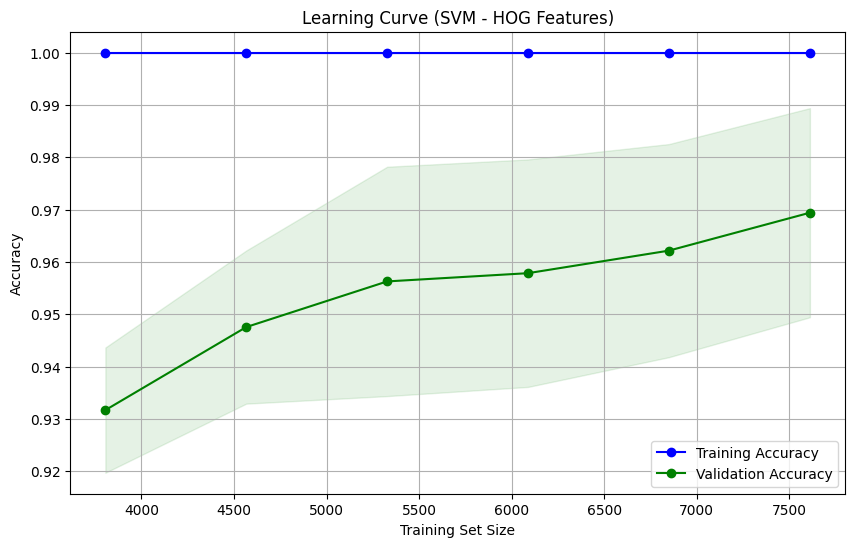

In [ ]:
# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
# Shaded area for std
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')
plt.title("Learning Curve (SVM - HOG Features)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid(True)
plt.show()

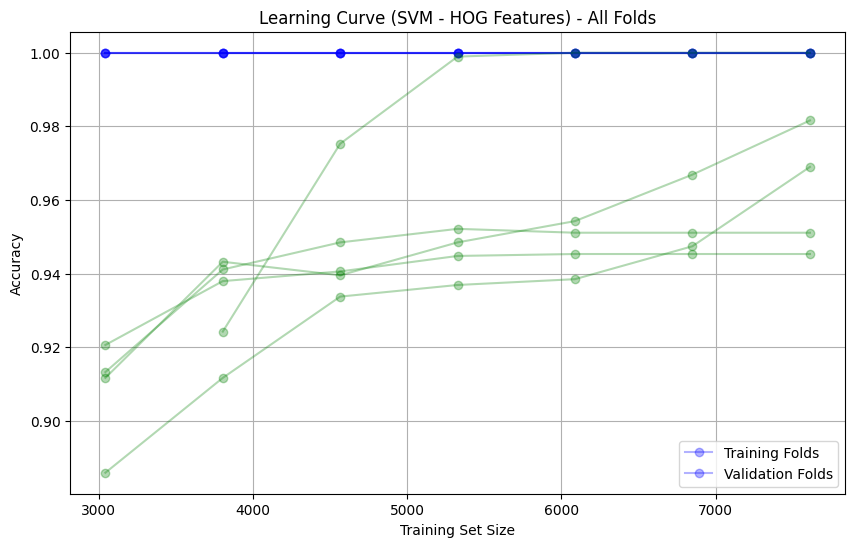

In [ ]:
import matplotlib.pyplot as plt

# Plot learning curves for all folds
plt.figure(figsize=(10, 6))

# Plot each training fold
for i in range(train_scores.shape[1]):  # train_scores.shape = (n_train_sizes, n_folds)
    plt.plot(train_sizes, train_scores[:, i], 'o-', color='blue', alpha=0.3)

# Plot each validation fold
for i in range(val_scores.shape[1]):
    plt.plot(train_sizes, val_scores[:, i], 'o-', color='green', alpha=0.3)

plt.title("Learning Curve (SVM - HOG Features) - All Folds")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(['Training Folds', 'Validation Folds'])
plt.grid(True)
plt.show()


In [ ]:
# Final training on full training data
clf.fit(X_train, y_train_enc)

SVC(kernel='linear', probability=True)

In [ ]:
# Evaluate on test set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test_enc, y_pred)
print(f"Test Accuracy: {acc:.2%}")
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred, target_names=le.classes_))

Test Accuracy: 96.29%

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.94      0.97      0.95       234
   PNEUMONIA       0.98      0.96      0.97       386

    accuracy                           0.96       620
   macro avg       0.96      0.96      0.96       620
weighted avg       0.96      0.96      0.96       620



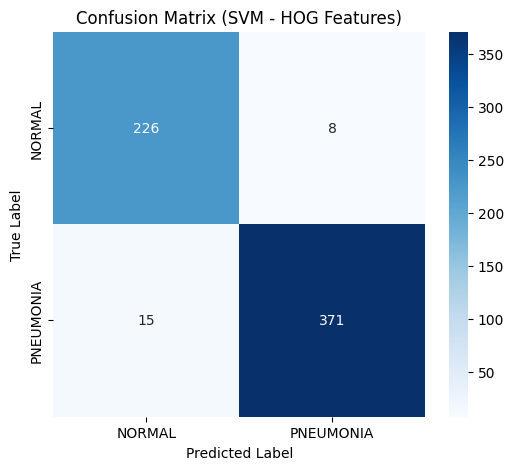

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (SVM - HOG Features)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
import joblib

# Save the trained SVM model
joblib.dump(clf, 'svm_hog_model.pkl')
print("Model saved successfully!")


Model saved successfully!


In [ ]:
import joblib

# Save the trained SVM model with compression
joblib.dump(clf, 'svm_hog_model_compressed.pkl', compress=3)
print("Model saved successfully with compression!")


Model saved successfully with compression!


In [ ]:
from google.colab import files
# Download the model file
files.download('svm_hog_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
# Download the model file
files.download('svm_hog_model_compressed.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
from skimage.feature import hog
import numpy as np
import joblib

# Load the saved model
clf = joblib.load('svm_hog_model.pkl')

# Path to your image
image_path = '/BACTERIA-4059589-0003.jpeg'  # replace with your image path

# Load and preprocess the image
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))

# Extract HOG features
features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
features = features.reshape(1, -1)  # Reshape for prediction

# Predict
pred = clf.predict(features)

# Map prediction to label
label_map = {0: 'normal', 1: 'pneumonia'}
print(f"Predicted class: {label_map[pred[0]]}")


Predicted class: pneumonia
